# Post Deployment Data QA Desktop Search Instrumentation

Tasks:
* **A/B Test Setup for Search Changes** [T259250](https://phabricator.wikimedia.org/T259250)
* **SearchSatisfaction Changes** [T262300](https://phabricator.wikimedia.org/T262300)

QA Doc: https://docs.google.com/spreadsheets/d/1DpuXcpUdFPqsupiyeDpNH50NiISNWP1c3VwiEK9zqpw/edit#gid=0

## Overview

In [T256100](https://phabricator.wikimedia.org/T256100), we added a skin version field and new values for the inputLocation and extraParams fields to record data as part of the following two AB tests on deployed search changes: 
1) The first on the new location of the search widget.
2) The second on the new widget / experience we're currently building in Vue.js.

These two A/B tests together support four possible configurations:

|skinVersion|	inputLocation|	extraParams	|Description|
|:--------|:--------|:--------|:--------|
|legacy|	"header-navigation"|	|	Vector Legacy skin with Legacy search (current master)|
|latest|	"header-navigation"|	|	Vector Latest skin with Legacy search (current master)|
|latest|	"header-moved"|		|Vector Latest skin with Legacy search and latest location|
|latest|	"header-moved"|	"WVUI"|	Vector Latest skin with Latest search and latest location|


The new location of the search functionarily was deployed to all projects on 28 September 2020. The new location is available by default for anonymous users, and by preference for all other users.

We are performing an A/B test of the new location with logged-in users on our early adopter wikis. 50% of logged-in users are seeing the new experience, while the other 50% are seeing the old experience. The test only applies to users on modern vector.


The [SearchSatisfaction Schema](https://meta.wikimedia.org/wiki/Schema:SearchSatisfaction) will be used to track events from these changes.

Note: Bucketing is done on a search session basis. 

I checked the following scenarios:
* Check events and distinct sessions per header location (IN PROGRESS - NEED TO BREAK DOWN BY LOGGED IN AND LOGGED OUT USERS)
* Check that AB test is balanced (TODO - PENDING ADDITION OF ISA NON FIELD)
* Check date when events started coming in and the number of events appear as expected (PASSED)
* Correct inputLocations associated with each skin version (header-moved should not be recorded with legacy) (FAILED)
* Check that skinVersion is only recorded when skin is vector (PASSED)
* Check associated actions and sources (PASSED)
* Check events appear for wikis as expected (PASSED)
* Check trend of logged in and logged out sessions and events. (TODO) 

In [66]:
# collect data from SearchSatisfaction for the relevant fields.
query <- 
"SELECT
    event.inputLocation AS search_location,
    event.searchSessionId AS search_session,
    event.skinVersion AS vector_version,
    event.action AS action_type,
    event.source AS source_type,
    event.skin AS skin_type,
    wiki AS wiki,
    Count(*) AS events
FROM event.searchSatisfaction
-- review a few days prior to check when data started to come in
    WHERE year = 2020 and ((month = 09 and day >= 28) OR month >= 10) 
GROUP BY 
    event.inputLocation,
    event.searchSessionId,
    event.skinVersion,
    event.action,
    event.source,
    event.skin,
    wiki"


In [67]:
search_sessions <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



## Total number of events and sessions per header location across all Wikis

In [68]:
# overall
search_sessions_bylocation <-search_sessions %>%
# limit to search events completed in two new locations
    filter(search_location %in% c('header-moved', 'header-navigation')) %>%
    group_by(search_location) %>%
    summarise(unique_sessions = n_distinct(search_session),
             total_events = sum(events)) 

search_sessions_bylocation

`summarise()` ungrouping output (override with `.groups` argument)



search_location,unique_sessions,total_events
<chr>,<int>,<int>
header-moved,34126954,245853447
header-navigation,21904762,152213782


There are more header-moved events as expected but it seems like the difference between the two groups should be be larger given that all logged out users are shown header-moved by default. Need to do further investigation once we are able to decipher between logged-out and logged-in users. 

Note: This might be related to inaccurate logging of some header-moved events on legacy.

## Search Location Events for AB Test Users on Test Wikis

 We ran a check to confirm that it was deployed to 50% of users (using the modern vector skin) on each wiki as part of the AB test. Bucketing is done on a search session basis so we can review the number of distinct sessions.

TODO: ANON field being added to be able to filter by logged in and logged out users.

## Search Location by Vector Version and Skin Type on All Wikis

In [69]:
search_location_check <- search_sessions %>%
    filter(search_location %in% c('header-navigation', 'header-moved')) %>%
    group_by(search_location, vector_version, skin_type) %>%
    summarise(num_events = sum(events),
             num_sessions = n_distinct(search_session))
search_location_check

`summarise()` regrouping output by 'search_location', 'vector_version' (override with `.groups` argument)



search_location,vector_version,skin_type,num_events,num_sessions
<chr>,<chr>,<chr>,<int>,<int>
header-moved,latest,vector,22098061,2739324
header-moved,legacy,vector,223752430,31387422
header-moved,NULL,NULL,2956,516
header-navigation,latest,vector,3914585,561534
header-navigation,legacy,vector,148296694,21342907
header-navigation,NULL,NULL,2503,470


FAILED:

ISSUE: Confirmed that the two header location types are only being recorded for the vector skin type; however, there are a large number header-moved events being recorded with legacy, which is not expected. There are also some header location events being recorded without an associated vector_version or skin.

I will further review by wiki and day below to confirm when these events started occuring.

### Further Investigate Legacy Events

In [109]:
## collect all search events with new header recorded on legacy by date.

query <- 
"SELECT
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) as date,
    event.inputLocation AS search_location,
    event.skin as skin_type,
    event.skinVersion AS vector_version,
    event.searchSessionId AS search_session,
    wiki,
    Count(*) as events
FROM event.searchSatisfaction 
-- review a few days prior to check when data started to come in
    WHERE year = 2020 AND ((month = 09 and day >= 20) OR month >= 10) 
-- review autocomplete searches on legacy
    AND event.action = 'searchResultPage'
    AND event.source = 'autocomplete'
    AND event.skinVersion = 'legacy'
    AND event.skin = 'vector'
GROUP BY 
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
    event.inputLocation,
    event.skin,
    event.skinVersion,
    event.searchSessionId,
    wiki"

In [110]:
search_sessions_legacy <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [111]:
search_sessions_legacy$date <- as.Date(search_sessions_legacy$date, format = "%Y-%m-%d")

### Legacy Events with New Header Location By Date

In [152]:
legacy_sessions_withnewsearchloc <- search_sessions_legacy %>%
    filter(search_location == 'header-moved') %>%
    group_by(date, vector_version) %>%
    summarise(num_events = sum(events),
             num_sessions = n_distinct(search_session)) %>%
    arrange(date)

legacy_sessions_withnewsearchloc

`summarise()` regrouping output by 'date' (override with `.groups` argument)



date,vector_version,num_events,num_sessions
<date>,<chr>,<int>,<int>
2020-09-22,legacy,6,3
2020-09-23,legacy,39,8
2020-09-24,legacy,124,8
2020-09-25,legacy,10,3
2020-09-26,legacy,38,6
2020-09-27,legacy,59,6
2020-09-28,legacy,1077,246
2020-09-29,legacy,4001,843
2020-09-30,legacy,1820093,264892


`summarise()` regrouping output by 'date', 'search_location' (override with `.groups` argument)



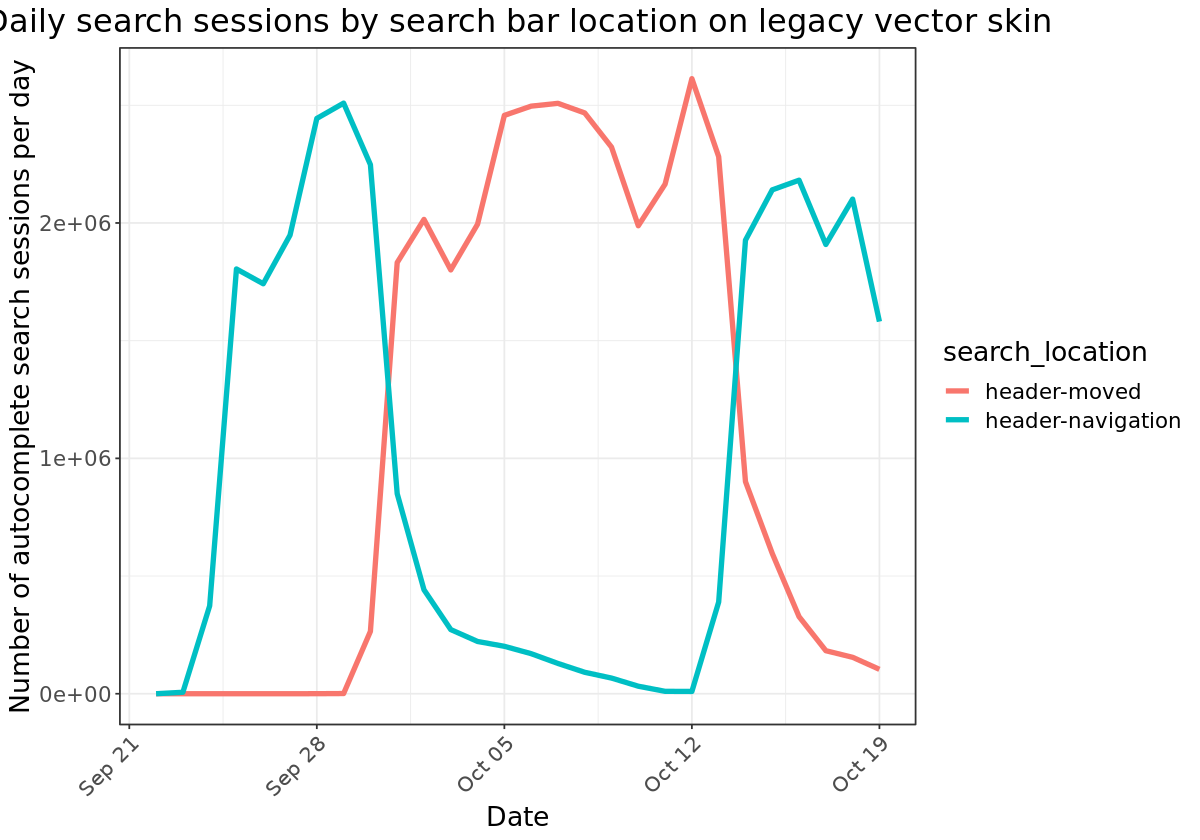

In [117]:
p <- search_sessions_legacy %>%
# compare header-moved to header-navigation dates
    filter(search_location %in% c('header-moved', 'header-navigation')) %>%
    group_by(date, search_location, vector_version) %>%
    summarise(num_events = sum(events),
             num_sessions = n_distinct(search_session)) %>%
    ggplot(aes(x=date, y= num_sessions, color = search_location)) +
    geom_line(size = 1.5) +
    scale_y_continuous() +
    labs (y = "Number of autocomplete search sessions per day",
          x = "Date",
         title = "Daily search sessions by search bar location on legacy vector skin")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
 
p

In [118]:
ggsave("Figures/daily_legacy_search_events.png", p, width = 16, height = 8, units = "in", dpi = 300)

Header-moved events on legacy start recording around September 28th, the date of deployment. Unlike the latest skin, they appear to drop on Oct 14th and have continued to decrease since then.

### Further Investigate NULL events

In [123]:
## collect all search header events that do not have an associated vector skin
# Check number of events for each to see if roughly even or number of sessions?
query <- 
"SELECT
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) as date,
    event.inputLocation AS search_location,
    event.skinVersion as vector_version,
    event.searchSessionId AS search_session,
    wiki,
    Count(*) as events
FROM event.searchSatisfaction 
-- review a few days prior to check when data started to come in
    WHERE year = 2020 AND ((month = 09 and day >= 20) OR month >= 10) 
-- further investigate instance where no skin was recorded
    AND event.skinVersion is NULL
    AND event.skin IS NULL
    AND event.action = 'searchResultPage'
    AND event.source = 'autocomplete' 
GROUP BY 
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
    event.inputLocation,
    event.skinVersion,
    event.searchSessionId,
    wiki"

In [124]:
search_sessions_null <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [133]:
search_sessions_null$date <- as.Date(search_sessions_null$date, format = "%Y-%m-%d")

In [134]:
daily_search_sessions_null_events <-search_sessions_null %>%
    filter(search_location %in% c('header-navigation', 'header-moved')) %>%
    group_by(search_location, vector_version, date) %>%
    summarise(num_sessions = n_distinct(search_session),
             num_events = sum(events))  %>%
    arrange(date)

daily_search_sessions_null_events

`summarise()` regrouping output by 'search_location', 'vector_version' (override with `.groups` argument)



search_location,vector_version,date,num_sessions,num_events
<chr>,<chr>,<date>,<int>,<int>
header-navigation,NULL,2020-09-23,1,1
header-navigation,NULL,2020-09-24,24,121
header-navigation,NULL,2020-09-25,121,646
header-navigation,NULL,2020-09-26,124,710
header-navigation,NULL,2020-09-27,104,574
header-navigation,NULL,2020-09-28,126,677
header-navigation,NULL,2020-09-29,95,493
header-moved,NULL,2020-09-30,5,30
header-navigation,NULL,2020-09-30,72,376


`summarise()` regrouping output by 'date' (override with `.groups` argument)



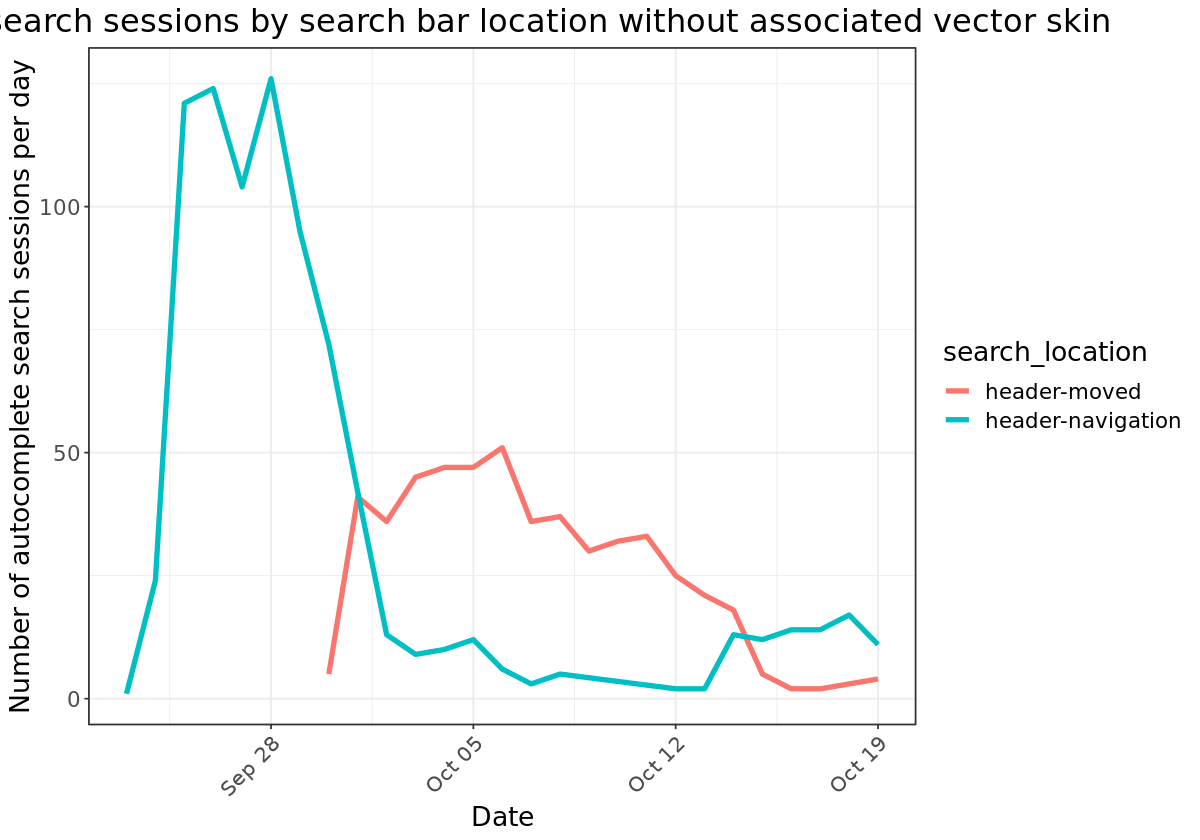

In [144]:
# plot null sessions
options(repr.plot.width = 10, repr.plot.height = 7)
p <- search_sessions_null %>%
# remove content - advanced search page searches
    filter(search_location %in% c('header-navigation', 'header-moved'))  %>%
    #filter(search_location != 'content') %>%
    group_by(date, search_location) %>%
    summarise(num_events = sum(events),
             num_sessions = n_distinct(search_session)) %>%
    ggplot(aes(x=date, y= num_sessions, color = search_location)) +
    geom_line(size = 1.5) +
    scale_y_continuous() +
    labs (y = "Number of autocomplete search sessions per day",
          x = "Date",
         title = "Daily search sessions by search bar location without associated vector skin")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
 
p

In [145]:
ggsave("Figures/daily_null_search_events.png", p, width = 16, height = 8, units = "in", dpi = 300)

Search events and sessions recorded as having a NULL vector skin version have been decreasing since deployment. Based on the trend lines show in chart below it looks like these NULL values are related to caching issues as the new instrumentation was deployed.  We're currently only recording less than 11 NULL sessions per day on each wiki and they seem to be decreasing still so I don't think this is an issue. 

## Search Location Events on Latest Skin by Date

In [ ]:
## collect all search header events by location
# Check number of events for each to see if roughly even or number of sessions?
query <- 
"SELECT
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) as date,
    event.inputLocation AS search_location,
    event.searchSessionId AS search_session,
    wiki,
    Count(*) as events
FROM event.searchSatisfaction 
-- review a few days prior to check when data started to come in
    WHERE year = 2020 AND ((month = 09 and day >= 20) OR month >= 10) 
-- only deployed on modern skin vector
    AND event.skinVersion = 'latest'
    AND event.skin = 'vector'
    AND event.action = 'searchResultPage'
    AND event.source = 'autocomplete' 
GROUP BY 
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
    event.inputLocation,
    event.searchSessionId,
    wiki"

In [ ]:
search_sessions_daily <-  wmfdata::query_hive(query)

In [ ]:
search_sessions_daily$date <- as.Date(search_sessions_daily$date, format = "%Y-%m-%d")

In [ ]:
daily_search_sessions <-search_sessions_daily %>%
#remove content- advanced page events
    filter(search_location != 'content')  %>%
    group_by(search_location, date) %>%
    summarise(unique_sessions = n_distinct(search_session),
             total_events = sum(events))  %>%
    arrange(date)
daily_search_sessions

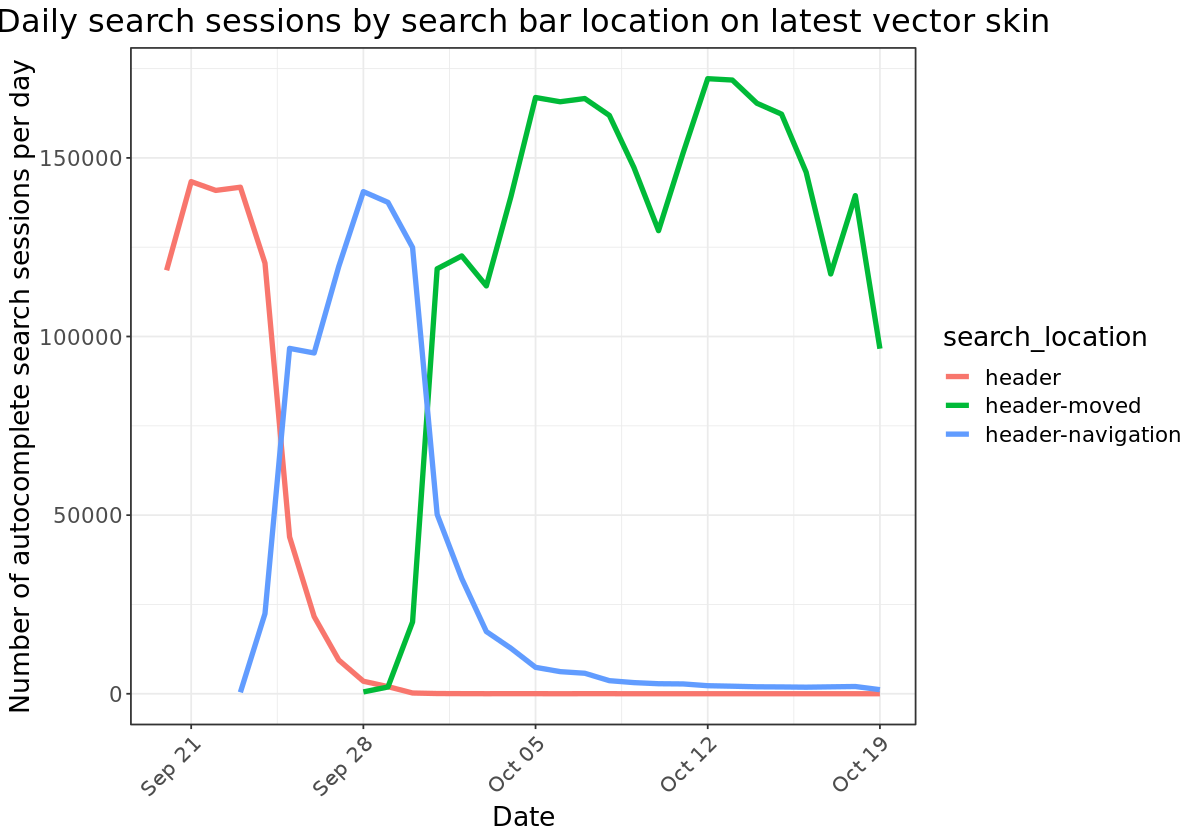

In [146]:
p <-daily_search_sessions %>%
    ggplot(aes(x=date, y= unique_sessions, color = search_location)) +
    geom_line(size = 1.5) +
    scale_y_continuous() +
    labs (y = "Number of autocomplete search sessions per day",
          x = "Date",
         title = "Daily search sessions by search bar location on latest vector skin")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
 
p

In [ ]:
ggsave("Figures/daily_latest_search_events.png", p, width = 16, height = 8, units = "in", dpi = 300)

The "header" location events are how the original search bar events were recorded prior to the instrumentation - these are events are dropping off as expected since it was replced by "header-navigation" events.

Header-moved(new search location) events start recording on the deployment date 28 September.  Following deployment, there is a signficant drop-off of header-navigation events. The decrease seems signficant but a decrease was expected since the new header was deployed as opt-out for all logged out users and 50% of logged in users.  An additional check of logged in vesus logged out users will help clarify.

## Review Search Location Events By Action and Source Type

In [86]:
action_type_check <- search_sessions %>%
    filter(search_location %in% c('header-navigation', 'header-moved')) %>%
    group_by(search_location, action_type, source_type) %>%
    summarise(events = sum(events))

action_type_check

`summarise()` regrouping output by 'search_location', 'action_type' (override with `.groups` argument)



search_location,action_type,source_type,events
<chr>,<chr>,<chr>,<int>
header-moved,searchResultPage,autocomplete,245853447
header-navigation,searchResultPage,autocomplete,152213782


PASSED:

The header-moved and header-navigation events are only recorded with action=`SearchResultPage` and `source='autocomplete'` events as expected.

## Review Search Location Events by Wiki

In [87]:
#how many wikis are seeing events
num_wikis_w_search_events <- search_sessions %>%
    filter(search_location %in% c('header-navigation', 'header-moved')) %>%
    group_by(search_location) %>%
    summarise(wikis = n_distinct(wiki))

num_wikis_w_search_events


`summarise()` ungrouping output (override with `.groups` argument)



search_location,wikis
<chr>,<int>
header-moved,740
header-navigation,736


There have been 740 wikis with header-moved events recorded and 721 wikis with header-navigation event recorded. Since this was deployed as default to all anonymous users, it might make since that there are some wikis that just have a header-moved events recorded.  

In [147]:
test_wiki_counts <- search_sessions %>%
    filter(search_location %in% c('header-navigation', 'header-moved'),
    ## review test wikis where deployed
     wiki %in% c('euwiki', 'frwiki', 'hewiki', 'ptwikiversity', 'frwiktionary', 'fawiki')) %>%
    group_by(search_location, wiki) %>%
    summarise(events = sum(events),
             sessions = n_distinct(search_session))  %>%
    arrange(wiki)

test_wiki_counts 


`summarise()` regrouping output by 'search_location' (override with `.groups` argument)



search_location,wiki,events,sessions
<chr>,<chr>,<int>,<int>
header-moved,euwiki,225135,23767
header-navigation,euwiki,41189,5062
header-moved,fawiki,856446,113597
header-navigation,fawiki,146172,22436
header-moved,frwiki,19846173,2387257
header-navigation,frwiki,3599525,504744
header-moved,frwiktionary,1053007,150538
header-navigation,frwiktionary,202592,35755
header-moved,hewiki,104123,62044


In [148]:
## Review non test wikis to see what the difference is

nontest_wiki_counts <- search_sessions %>%
    filter(search_location %in% c('header-navigation', 'header-moved'),
    ## review some non-test wikis where deployed
     wiki %in% c('enwiki', 'eswiki', 'ruwiki', 'zhwiki', 'dewiki')) %>%
    group_by(search_location, wiki) %>%
    summarise(events = sum(events),
             sessions = n_distinct(search_session))  %>%
    arrange(wiki)

nontest_wiki_counts 

`summarise()` regrouping output by 'search_location' (override with `.groups` argument)



search_location,wiki,events,sessions
<chr>,<chr>,<int>,<int>
header-moved,dewiki,28193776,3931976
header-navigation,dewiki,16892186,2448408
header-moved,enwiki,131301289,18012738
header-navigation,enwiki,89861588,12712198
header-moved,eswiki,11862622,1552497
header-navigation,eswiki,7585044,1010010
header-moved,ruwiki,11715096,1782348
header-navigation,ruwiki,7251294,1112779
header-moved,zhwiki,691572,300643


PASSED/IN PROGRESS:

There is between 4 to 5 times more header-moved events and sessions compared to the old header location on the test wikis. There are little more than twice the number of header-moved events compared to header-navigation events on the reviewed non-test wikis.

This difference is expected as on the test wikis the new header was also show as default 50% of all logged-in users. 

TODO: 
* Need to confirm difference between logged in and logged out users. Should there be more header-moved events for non-test wikis